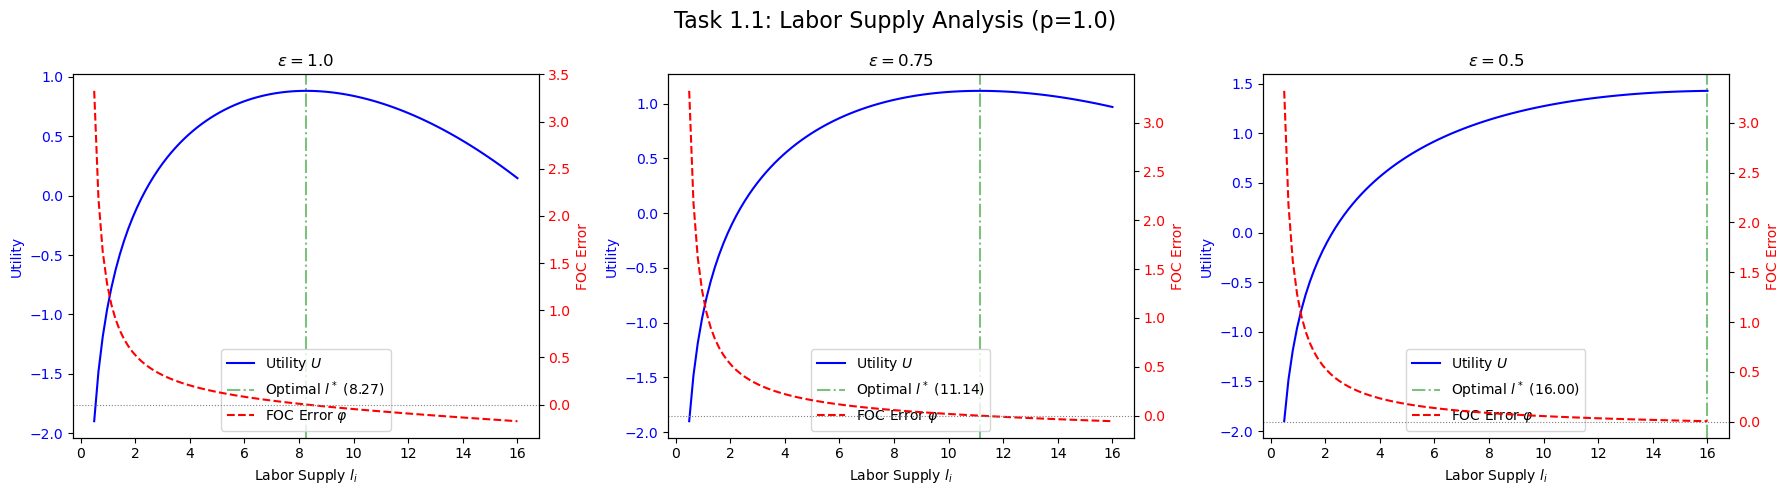

Epsilon    | Method       | Optimal l    | Time (s)    
-------------------------------------------------------
1.0        | Optimizer    | 8.265578     | 0.000105    
           | Root-finder  | 8.265578     | 0.000038    
-> For epsilon=1.0, the Root-finder was faster.

0.75       | Optimizer    | 11.136048    | 0.000086    
           | Root-finder  | 11.136048    | 0.000029    
-> For epsilon=0.75, the Root-finder was faster.

0.5        | Optimizer    | 15.999996    | 0.000209    
           | Root-finder  | 16.000000    | 0.000004    
-> For epsilon=0.5, the Root-finder was faster.



In [1]:
# Task 1 - Labor Supply.

# 1.1 Numerical optimizer vs root-finder

import time
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
from scipy.optimize import minimize_scalar, root_scalar

# --- Defined WorkerClass based on Worker.py ---
class WorkerClass:

    def __init__(self, par=None):
        self.setup_worker()
        if par is not None:
            for k, v in par.items():
                self.par.__dict__[k] = v

    def setup_worker(self):
        par = self.par = SimpleNamespace()

        # a. preferences
        par.nu = 0.015
        par.epsilon = 1.0
        
        # b. productivity and wages
        par.w = 1.0
        par.ell_max = 16.0
        
        # c. taxes
        par.tau = 0.50
        par.zeta = 0.10

    def utility(self, c, ell):
        par = self.par
        if c <= 0:
            return -np.inf
        return np.log(c) - par.nu * (ell**(1 + par.epsilon) / (1 + par.epsilon))
    
    def income(self, p, ell):
        par = self.par
        return par.w * p * ell

    def tax(self, pre_tax_income):
        par = self.par
        return par.tau * pre_tax_income + par.zeta

    def post_tax_income(self, p, ell):
        pre_tax = self.income(p, ell)
        return pre_tax - self.tax(pre_tax)

    def value_of_choice(self, p, ell):
        c = self.post_tax_income(p, ell)
        return self.utility(c, ell)
    
    def get_min_ell(self, p):
        par = self.par
        denom = (1 - par.tau) * par.w * p
        if denom == 0:
            return 0.0
        min_ell = par.zeta / denom
        return np.maximum(min_ell, 0.0) + 1e-8
    
    def optimal_choice(self, p):
        par = self.par
        obj = lambda ell: -self.value_of_choice(p, ell)

        lb = self.get_min_ell(p)
        ub = par.ell_max

        res = minimize_scalar(obj, bounds=(lb, ub), method='bounded')
        return res.x, -res.fun

    def FOC(self, p, ell):
        par = self.par
        c = self.post_tax_income(p, ell)
        
        if c <= 0:
            return np.inf
        
        marginal_utility_c = 1 / c
        marginal_c_l = (1 - par.tau) * par.w * p
        marginal_disutility_l = par.nu * (ell**par.epsilon)
        
        return marginal_utility_c * marginal_c_l - marginal_disutility_l
    
    def optimal_choice_FOC(self, p):
        par = self.par
        
        lb = self.get_min_ell(p)
        ub = par.ell_max
        
        f_lb = self.FOC(p, lb)
        f_ub = self.FOC(p, ub)
        
        if f_lb > 0 and f_ub > 0:
            return ub
        elif f_lb < 0 and f_ub < 0:
            return lb
        
        # Only call root_scalar when bracket is valid
        res = root_scalar(lambda l: self.FOC(p, l), bracket=[lb, ub], method='brentq')
        return res.root


# 1.1 Execution 

epsilons = [1.0, 0.75, 0.50]
p_val = 1.0
l_grid = np.linspace(0.5, 16, 100)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(f"Task 1.1: Labor Supply Analysis (p={p_val})", fontsize=16)

results_table = []

for i, eps in enumerate(epsilons):

    model = WorkerClass({'epsilon': eps})
    
    u_vals = []
    foc_vals = []
    
    for l in l_grid:
        u_vals.append(model.value_of_choice(p_val, l))
        foc_vals.append(model.FOC(p_val, l))
    
    # Numerical Optimizer
    t0 = time.time()
    l_opt_num, _ = model.optimal_choice(p_val)
    t1 = time.time()
    time_num = t1 - t0
    
    # Root-Finder
    t0 = time.time()
    l_opt_root = model.optimal_choice_FOC(p_val)
    t1 = time.time()
    time_root = t1 - t0
    
    results_table.append({
        'eps': eps,
        'l_num': l_opt_num,
        'time_num': time_num,
        'l_root': l_opt_root,
        'time_root': time_root
    })

    ax = axes[i]
    ax2 = ax.twinx()
    
    ax.plot(l_grid, u_vals, 'b-', label='Utility $U$')
    ax.set_xlabel('Labor Supply $l_i$')
    ax.set_ylabel('Utility', color='b')
    ax.tick_params(axis='y', labelcolor='b')
    
    ax2.plot(l_grid, foc_vals, 'r--', label='FOC Error $\\varphi$')
    ax2.axhline(0, color='grey', linewidth=0.8, linestyle=':')
    ax2.set_ylabel('FOC Error', color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    ax.axvline(l_opt_num, color='g', linestyle='-.', alpha=0.5,
               label=f'Optimal $l^*$ ({l_opt_num:.2f})')
    
    ax.set_title(f'$\epsilon = {eps}$')
    
    lines_1, labels_1 = ax.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax.legend(lines_1 + lines_2, labels_1 + labels_2, loc='lower center')

plt.tight_layout()
plt.show()

print(f"{'Epsilon':<10} | {'Method':<12} | {'Optimal l':<12} | {'Time (s)':<12}")
print("-" * 55)
for res in results_table:
    print(f"{res['eps']:<10} | {'Optimizer':<12} | {res['l_num']:<12.6f} | {res['time_num']:<12.6f}")
    print(f"{'':<10} | {'Root-finder':<12} | {res['l_root']:<12.6f} | {res['time_root']:<12.6f}")
    
    if res['time_root'] < res['time_num']:
        faster = "Root-finder"
    else:
        faster = "Optimizer"
    print(f"-> For epsilon={res['eps']}, the {faster} was faster.\n")

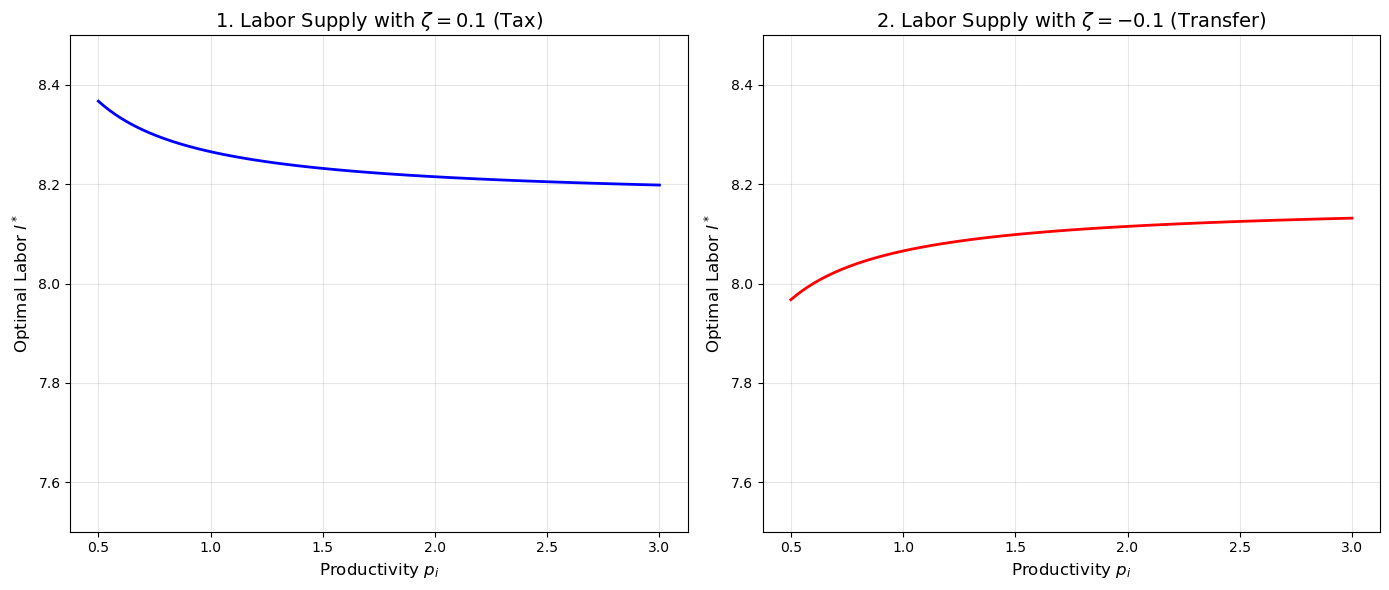

In [2]:
# 1.2 Labor supply function

# Data Generation
p_grid = np.linspace(0.5, 3.0, 100)

# Case 1: zeta = 0.1
worker_1 = WorkerClass({'zeta': 0.1})
l_star_1 = [worker_1.optimal_choice(p) for p in p_grid]

# Case 2: zeta = -0.1
worker_2 = WorkerClass({'zeta': -0.1})
l_star_2 = [worker_2.optimal_choice(p) for p in p_grid]

# Plotting - 2 Subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Standard Case
axes[0].plot(p_grid, l_star_1, 'b-', linewidth=2)
axes[0].set_title('1. Labor Supply with $\zeta = 0.1$ (Tax)', fontsize=14)
axes[0].set_xlabel('Productivity $p_i$', fontsize=12)
axes[0].set_ylabel('Optimal Labor $l^*$', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(7.5, 8.5)

# Plot 2: Transfer Case
axes[1].plot(p_grid, l_star_2, 'r-', linewidth=2)
axes[1].set_title('2. Labor Supply with $\zeta = -0.1$ (Transfer)', fontsize=14)
axes[1].set_xlabel('Productivity $p_i$', fontsize=12)
axes[1].set_ylabel('Optimal Labor $l^*$', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(7.5, 8.5)

plt.tight_layout()
plt.show()

T(0.50, 0.1) = 417.91
SWF(0.50, 0.1) = 174.05
Global max SWF occurs at zeta=-0.1, tau≈0.07, SWF=222.23


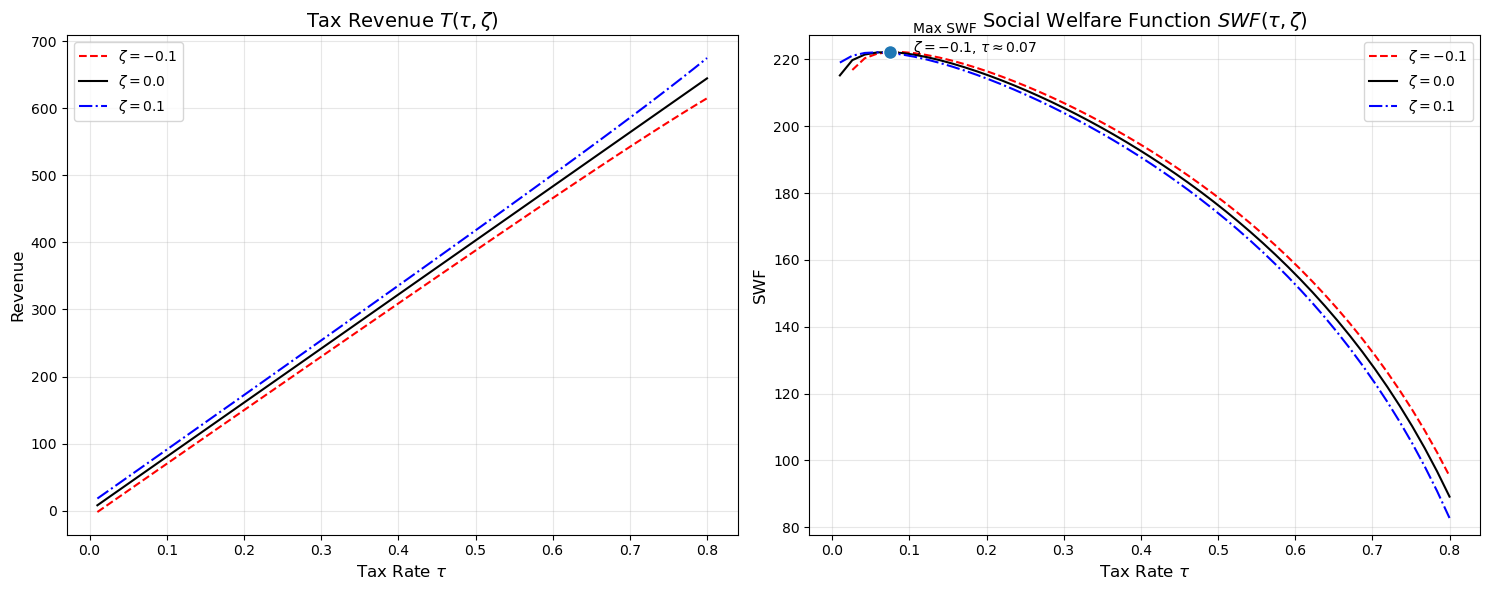

In [3]:
# Task 2.1 - Public Good.

# Class: Government (WorkerClass is already defined earlier in the notebook) 

class GovernmentClass(WorkerClass):
    def __init__(self, par=None):
        super().__init__(par)
        self.setup_government()
        self.rng = np.random.default_rng(12345)

    def setup_government(self):
        par = self.par
        par.N = 100
        par.sigma_p = 0.3
        par.chi = 50.0
        par.eta = 0.1

    def draw_productivities(self):
        par = self.par
        mu = -0.5 * par.sigma_p**2
        self.p_vec = self.rng.lognormal(mu, par.sigma_p, par.N)

    def compute_swf(self, tau, zeta):
        par = self.par
        par.tau = tau
        par.zeta = zeta

        total_tax_revenue = 0.0
        total_utility = 0.0

        for p in self.p_vec:
            ell, u = self.optimal_choice(p)  
            total_tax_revenue += (par.tau * par.w * p * ell + par.zeta)
            total_utility += u

        if total_tax_revenue < 0:
            return total_tax_revenue, -np.inf

        swf = par.chi * (total_tax_revenue**par.eta) + total_utility
        return total_tax_revenue, swf


# Execution & Plotting 

gov = GovernmentClass()
gov.draw_productivities()

T_05, SWF_05 = gov.compute_swf(0.50, 0.1)
print(f"T(0.50, 0.1) = {T_05:.2f}")
print(f"SWF(0.50, 0.1) = {SWF_05:.2f}")

tau_grid = np.linspace(0.01, 0.80, 50)
zeta_grid = [-0.1, 0.0, 0.1]

results = {z: {"T": [], "SWF": []} for z in zeta_grid}

for z in zeta_grid:
    for t in tau_grid:
        T, val = gov.compute_swf(t, z)
        results[z]["T"].append(T)
        results[z]["SWF"].append(val)

# Create Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
colors = ["red", "black", "blue"]
styles = ["--", "-", "-."]

for i, z in enumerate(zeta_grid):
    axes[0].plot(tau_grid, results[z]["T"], color=colors[i], linestyle=styles[i], label=f"$\\zeta = {z}$")

    swf_vals = np.array(results[z]["SWF"])
    axes[1].plot(tau_grid, swf_vals, color=colors[i], linestyle=styles[i], label=f"$\\zeta = {z}$")

# Find GLOBAL max SWF across all (zeta, tau) 
best_z = None
best_tau = None
best_swf = -np.inf

for z in zeta_grid:
    swf_vals = np.array(results[z]["SWF"])
    finite_mask = np.isfinite(swf_vals)
    if not np.any(finite_mask):
        continue

    local_idx = np.argmax(swf_vals[finite_mask])
    tau_candidates = tau_grid[finite_mask]
    swf_candidates = swf_vals[finite_mask]

    if swf_candidates[local_idx] > best_swf:
        best_swf = swf_candidates[local_idx]
        best_tau = tau_candidates[local_idx]
        best_z = z

# Mark ONLY the global max point on SWF plot
axes[1].plot(best_tau, best_swf, "o", markersize=10, markeredgecolor="white")

axes[1].annotate(
    f"Max SWF\n$\\zeta={best_z}$, $\\tau\\approx{best_tau:.2f}$",
    xy=(best_tau, best_swf),
    xytext=(best_tau + 0.03, best_swf),
)

print(f"Global max SWF occurs at zeta={best_z}, tau≈{best_tau:.2f}, SWF={best_swf:.2f}")

# Formatting Plot 1 (Revenue)
axes[0].set_title("Tax Revenue $T(\\tau, \\zeta)$", fontsize=14)
axes[0].set_xlabel("Tax Rate $\\tau$", fontsize=12)
axes[0].set_ylabel("Revenue", fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Formatting Plot 2 (SWF) - Dynamic Limits
axes[1].set_title("Social Welfare Function $SWF(\\tau, \\zeta)$", fontsize=14)
axes[1].set_xlabel("Tax Rate $\\tau$", fontsize=12)
axes[1].set_ylabel("SWF", fontsize=12)

all_swf = []
for z in zeta_grid:
    all_swf.extend([v for v in results[z]["SWF"] if np.isfinite(v)])

if all_swf:
    y_min = min(all_swf) - 5
    y_max = max(all_swf) + 5
    axes[1].set_ylim(y_min, y_max)

axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

1. Optimizing...
Optimal Result: tau=0.1368, zeta=-0.5236, SWF=222.3841

2. Verifying starting values...
 Start [0.2, 0.2] -> tau=0.1368, zeta=-0.5236, SWF=222.3841
 Start [0.8, 0.05] -> tau=0.1368, zeta=-0.5236, SWF=222.3841
 Start [0.5, 0.5] -> tau=0.1368, zeta=-0.5236, SWF=222.3841

3. Generating Plots...


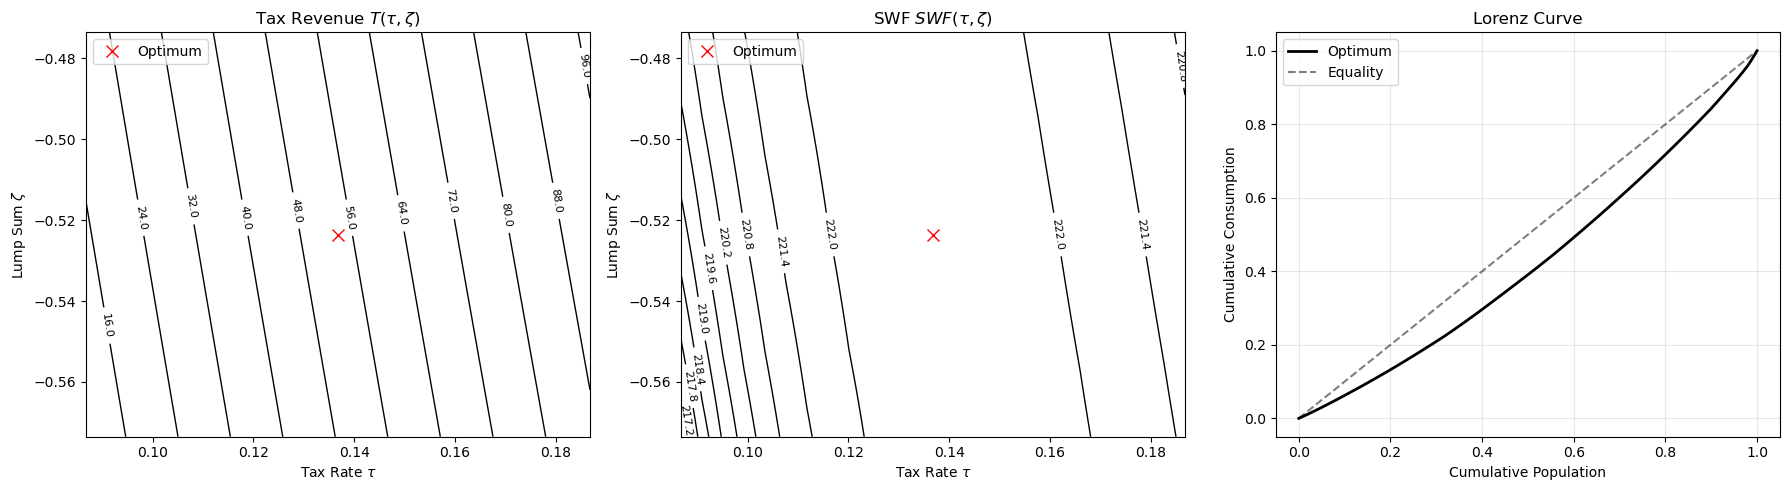

In [4]:
# 2.2 Optimal tax system

from scipy.optimize import minimize

# 1. Define Model Classes (same as before)
class WorkerClass:
    def __init__(self, par=None):
        self.par = SimpleNamespace()
        self.setup_worker()
        if par is not None:
            for k, v in par.items():
                self.par.__dict__[k] = v

    def setup_worker(self):
        par = self.par
        par.nu = 0.015
        par.epsilon = 1.0
        par.w = 1.0
        par.ell_max = 16.0
        par.tau = 0.50
        par.zeta = 0.10

    def utility(self, c, ell):
        par = self.par
        if c <= 0:
            return -np.inf
        return np.log(c) - par.nu * (ell**(1 + par.epsilon) / (1 + par.epsilon))

    def post_tax_income(self, p, ell):
        par = self.par
        return (1 - par.tau) * par.w * p * ell - par.zeta

    def optimal_choice(self, p):
        par = self.par
        denom = (1 - par.tau) * par.w * p
        if denom <= 0:
            return np.nan, np.nan, -np.inf

        lb = np.maximum(par.zeta / denom, 0.0) + 1e-8

        if lb >= par.ell_max:
            ell = par.ell_max
            c = self.post_tax_income(p, ell)
            u = self.utility(c, ell)
            return ell, c, u

        obj = lambda ell: -self.utility(self.post_tax_income(p, ell), ell)
        res = minimize_scalar(obj, bounds=(lb, par.ell_max), method='bounded')

        ell_star = res.x
        c_star = self.post_tax_income(p, ell_star)
        u_star = -res.fun
        return ell_star, c_star, u_star


class GovernmentClass(WorkerClass):
    def __init__(self, par=None):
        super().__init__(par)
        self.setup_government()
        self.rng = np.random.default_rng(12345)

    def setup_government(self):
        par = self.par
        par.N = 100
        par.sigma_p = 0.3
        par.chi = 50.0
        par.eta = 0.1

    def draw_productivities(self):
        par = self.par
        mu = -0.5 * par.sigma_p**2
        self.p_vec = self.rng.lognormal(mu, par.sigma_p, par.N)

    def compute_swf_and_revenue(self, tau, zeta):
        par = self.par
        par.tau = tau
        par.zeta = zeta
        
        # Constraint: Poorest worker must have positive consumption
        p_min = np.min(self.p_vec)
        limit_zeta = (1 - par.tau) * par.w * p_min * par.ell_max
        if par.zeta >= limit_zeta:
            return -np.inf, -np.inf

        total_tax_revenue = 0.0
        total_utility = 0.0
        
        for p in self.p_vec:
            ell, c, u = self.optimal_choice(p)
            if u == -np.inf:
                return -np.inf, -np.inf

            tax_i = par.tau * par.w * p * ell + par.zeta
            total_tax_revenue += tax_i
            total_utility += u
            
        if total_tax_revenue < 0:
            return total_tax_revenue, -np.inf
            
        swf = par.chi * (total_tax_revenue**par.eta) + total_utility
        return total_tax_revenue, swf


# Execution 
gov = GovernmentClass()
gov.draw_productivities()

def objective(x):
    t, z = x
    if t < 0 or t > 0.99:
        return np.inf
    _, swf = gov.compute_swf_and_revenue(t, z)
    if swf == -np.inf:
        return np.inf
    return -swf

# 1. Optimize
print("1. Optimizing...")
res = minimize(objective, [0.5, 0.1], method='Nelder-Mead', tol=1e-4)
opt_tau = res.x[0]
opt_zeta = res.x[1]
opt_swf = -res.fun
print(f"Optimal Result: tau={opt_tau:.4f}, zeta={opt_zeta:.4f}, SWF={opt_swf:.4f}")

# 2. Verify Robustness
print("\n2. Verifying starting values...")
start_guesses = [[0.2, 0.2], [0.8, 0.05], [0.5, 0.5]]
for g in start_guesses:
    r = minimize(objective, g, method='Nelder-Mead', tol=1e-4)
    print(f" Start {g} -> tau={r.x[0]:.4f}, zeta={r.x[1]:.4f}, SWF={-r.fun:.4f}")

# 3. Plotting
print("\n3. Generating Plots...")
delta_tau = 0.05
delta_zeta = 0.05
tau_vec = np.linspace(opt_tau - delta_tau, opt_tau + delta_tau, 25)
zeta_vec = np.linspace(opt_zeta - delta_zeta, opt_zeta + delta_zeta, 25)
T_mesh, Z_mesh = np.meshgrid(tau_vec, zeta_vec)
swf_grid = np.zeros_like(T_mesh)
rev_grid = np.zeros_like(T_mesh)

for i in range(len(zeta_vec)):
    for j in range(len(tau_vec)):
        rev, val = gov.compute_swf_and_revenue(T_mesh[i, j], Z_mesh[i, j])
        rev_grid[i, j] = rev
        swf_grid[i, j] = val

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

CS1 = axes[0].contour(T_mesh, Z_mesh, rev_grid, levels=10, colors='black', linewidths=1)
axes[0].clabel(CS1, inline=True, fontsize=8, fmt='%.1f')
axes[0].plot(opt_tau, opt_zeta, 'rx', markersize=8, label='Optimum')
axes[0].set_title('Tax Revenue $T(\\tau, \\zeta)$')
axes[0].set_xlabel('Tax Rate $\\tau$')
axes[0].set_ylabel('Lump Sum $\\zeta$')
axes[0].legend()

CS2 = axes[1].contour(T_mesh, Z_mesh, swf_grid, levels=10, colors='black', linewidths=1)
axes[1].clabel(CS2, inline=True, fontsize=8, fmt='%.1f')
axes[1].plot(opt_tau, opt_zeta, 'rx', markersize=8, label='Optimum')
axes[1].set_title('SWF $SWF(\\tau, \\zeta)$')
axes[1].set_xlabel('Tax Rate $\\tau$')
axes[1].set_ylabel('Lump Sum $\\zeta$')
axes[1].legend()

# Plot C: Lorenz Curve
consumptions = []
gov.par.tau = opt_tau
gov.par.zeta = opt_zeta
for p in gov.p_vec:
    _, c, _ = gov.optimal_choice(p)
    consumptions.append(c)

consumptions = np.sort(consumptions)
cum_pop = np.arange(1, gov.par.N + 1) / gov.par.N
cum_cons = np.cumsum(consumptions) / np.sum(consumptions)
cum_pop = np.insert(cum_pop, 0, 0)
cum_cons = np.insert(cum_cons, 0, 0)

axes[2].plot(cum_pop, cum_cons, 'k-', linewidth=2, label='Optimum')
axes[2].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Equality')
axes[2].set_title('Lorenz Curve')
axes[2].set_xlabel('Cumulative Population')
axes[2].set_ylabel('Cumulative Consumption')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

--- Task 3.1: Labor Supply Analysis ---
p=1.0: 4-step l*=7.8673 (Below), numerical l*=7.8673
p=1.175: 4-step l*=7.6596 (Kink), numerical l*=7.6596
p=1.5: 4-step l*=7.0802 (Above), numerical l*=7.0802


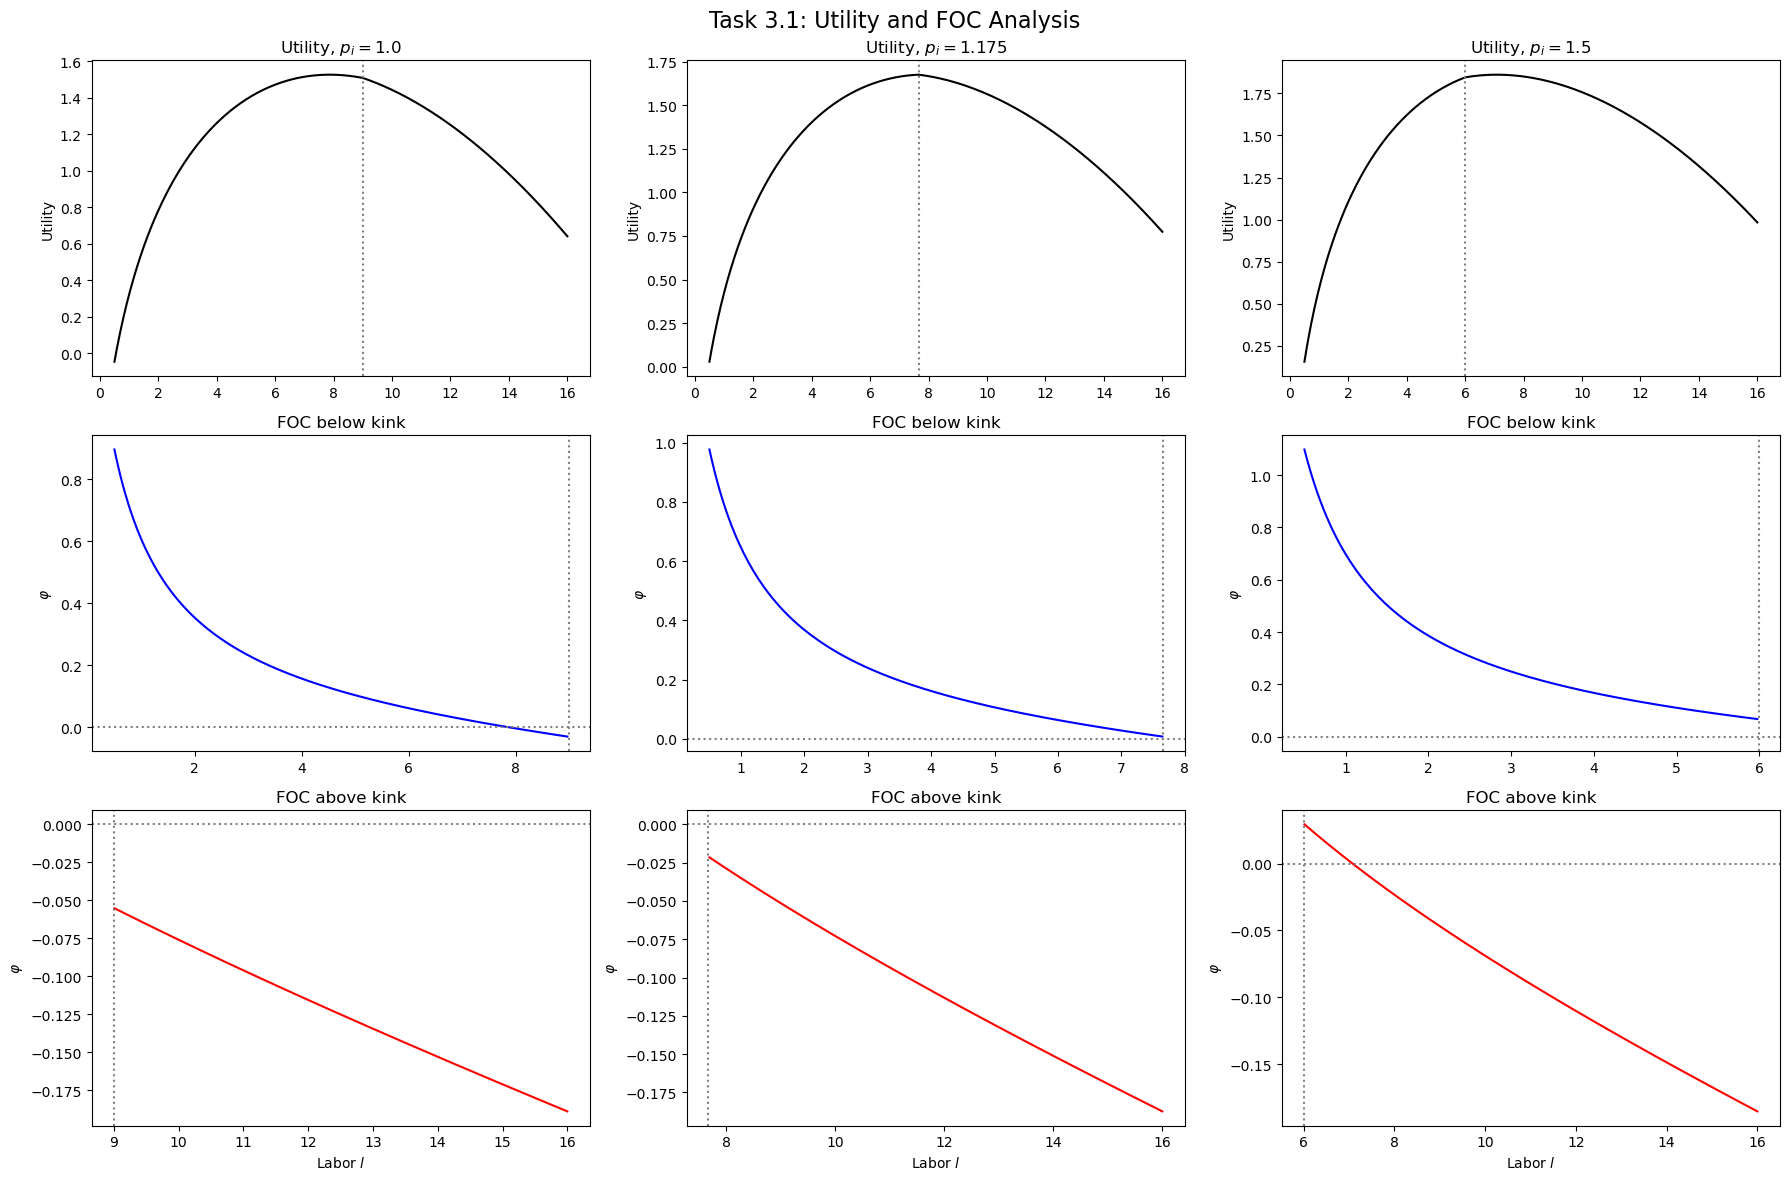


--- Task 3.2: Labor Supply Function ---


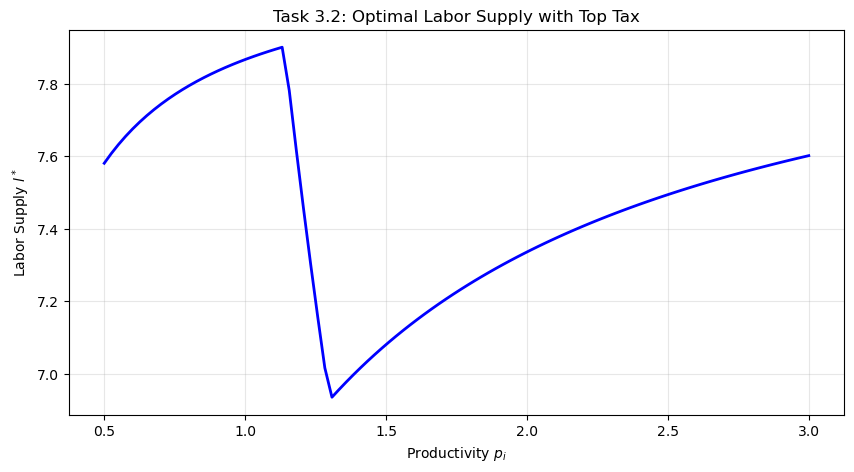

Proportions of workers:
  Below: 26.0%
  Kink: 6.0%
  Above: 68.0%

--- Task 3.3: Public Good & SWF ---
SWF with Top Tax (kappa=9.0, omega=0.2): 221.9337
SWF without top tax (omega=0): 222.3841
-> The Top Tax DECREASED social welfare.


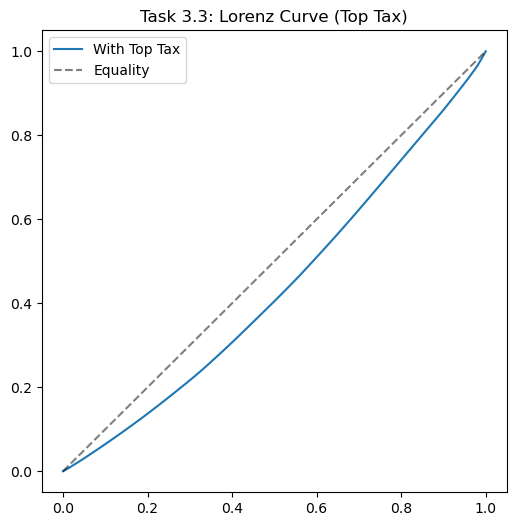


Searching for better Top Tax parameters...
Best found in grid: kappa=12.0, omega=0.05 -> SWF=222.3796


In [5]:
# Task 3 - Top tax

# 1. Define TopTaxWorkerClass 
class TopTaxWorkerClass:
    def __init__(self, par=None):
        self.par = SimpleNamespace()
        self.setup()
        if par is not None:
            for k, v in par.items():
                self.par.__dict__[k] = v

    def setup(self):
        par = self.par
        # Standard parameters
        par.nu = 0.015
        par.epsilon = 1.0
        par.w = 1.0
        par.ell_max = 16.0
        
        # Using optimal values found in Task 2.2 as the "Standard" system
        par.tau = 0.1368 
        par.zeta = -0.5236
        
        # Top Tax specific
        par.kappa = 9.0   # Cut-off
        par.omega = 0.20  # Top tax rate

    def utility(self, c, ell):
        par = self.par
        if c <= 0:
            return -np.inf
        return np.log(c) - par.nu * (ell**(1 + par.epsilon) / (1 + par.epsilon))

    def income(self, p, ell):
        return self.par.w * p * ell

    def tax(self, income):
        par = self.par
        # Standard tax
        t = par.tau * income + par.zeta
        # Top tax
        top_base = np.maximum(income - par.kappa, 0)
        t += par.omega * top_base
        return t

    def post_tax_income(self, p, ell):
        inc = self.income(p, ell)
        return inc - self.tax(inc)

    # FOC Definitions 
    def foc_error_lower(self, l, p):
        par = self.par
        c = (1 - par.tau) * par.w * p * l - par.zeta
        if c <= 0:
            return np.inf
        lhs = (1 - par.tau) * par.w * p / c
        rhs = par.nu * (l**par.epsilon)
        return lhs - rhs

    def foc_error_upper(self, l, p):
        par = self.par
        inc = par.w * p * l
    
        tax = par.tau * inc + par.zeta + par.omega * (inc - par.kappa)
        c = inc - tax
        
        if c <= 0:
            return np.inf
        
        lhs = (1 - par.tau - par.omega) * par.w * p / c
        rhs = par.nu * (l**par.epsilon)
        return lhs - rhs

    # Solvers 
    def optimal_choice_numerical(self, p):
        par = self.par
        obj = lambda l: -self.utility(self.post_tax_income(p, l), l)

        lb = 0.0 if par.zeta <= 0 else 1e-6
        res = minimize_scalar(obj, bounds=(lb, par.ell_max), method='bounded')
        return res.x, -res.fun

    def optimal_choice_4step(self, p):
        par = self.par
    
        l_kink = par.kappa / (par.w * p)
        
        candidates = []
        
        # Step 1: Lower Bracket Candidate (l < l_kink)
        lb = 1e-4
        if l_kink > lb:
            err_lb = self.foc_error_lower(lb, p)
            err_ub = self.foc_error_lower(l_kink, p)

            if err_lb > 0 and err_ub < 0:
                res = root_scalar(lambda l: self.foc_error_lower(l, p),
                                  bracket=[lb, l_kink], method='brentq')
                l_b = res.root
                u_b = self.utility(self.post_tax_income(p, l_b), l_b)
                candidates.append((l_b, u_b, 'Below'))

        # Step 2: Kink Candidate
        if 0 <= l_kink <= par.ell_max:
            u_k = self.utility(self.post_tax_income(p, l_kink), l_kink)
            candidates.append((l_kink, u_k, 'Kink'))

        # Step 3: Upper Bracket Candidate (l > l_kink)
        ub = par.ell_max
        if ub > l_kink:
            err_lb = self.foc_error_upper(l_kink, p)
            err_ub = self.foc_error_upper(ub, p)

            if err_lb > 0 and err_ub < 0:
                res = root_scalar(lambda l: self.foc_error_upper(l, p),
                                  bracket=[l_kink, ub], method='brentq')
                l_a = res.root
                u_a = self.utility(self.post_tax_income(p, l_a), l_a)
                candidates.append((l_a, u_a, 'Above'))
            
        # Step 4: Compare
        if not candidates:
            return 0.0, -np.inf, 'None'
        
        best = max(candidates, key=lambda x: x[1])
        return best  

# Execution 

print("--- Task 3.1: Labor Supply Analysis ---")
worker = TopTaxWorkerClass()

p_cases = [1.0, 1.175, 1.5]

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle('Task 3.1: Utility and FOC Analysis', fontsize=16)

for j, p in enumerate(p_cases):

    l_grid = np.linspace(0.5, worker.par.ell_max, 400)
    l_kink = worker.par.kappa / (worker.par.w * p)

    u_vals = [worker.utility(worker.post_tax_income(p, l), l) for l in l_grid]
    axes[0, j].plot(l_grid, u_vals, 'k-')
    axes[0, j].axvline(l_kink, color='gray', linestyle=':')
    axes[0, j].set_title(f'Utility, $p_i={p}$')
    axes[0, j].set_ylabel('Utility')

    l_below = l_grid[l_grid < l_kink]
    phi_below = [worker.foc_error_lower(l, p) for l in l_below]
    axes[1, j].plot(l_below, phi_below, 'b-')
    axes[1, j].axhline(0, color='gray', linestyle=':')
    axes[1, j].axvline(l_kink, color='gray', linestyle=':')
    axes[1, j].set_title('FOC below kink')
    axes[1, j].set_ylabel(r'$\varphi$')

    l_above = l_grid[l_grid > l_kink]
    phi_above = [worker.foc_error_upper(l, p) for l in l_above]
    axes[2, j].plot(l_above, phi_above, 'r-')
    axes[2, j].axhline(0, color='gray', linestyle=':')
    axes[2, j].axvline(l_kink, color='gray', linestyle=':')
    axes[2, j].set_title('FOC above kink')
    axes[2, j].set_xlabel('Labor $l$')
    axes[2, j].set_ylabel(r'$\varphi$')

    l_4, u_4, t_4 = worker.optimal_choice_4step(p)
    l_n, u_n = worker.optimal_choice_numerical(p)

    print(f"p={p}: 4-step l*={l_4:.4f} ({t_4}), numerical l*={l_n:.4f}")

plt.tight_layout()
plt.show()

print("\n--- Task 3.2: Labor Supply Function ---")

p_grid = np.linspace(0.5, 3.0, 100)
l_results = []
types_count = {'Below': 0, 'Kink': 0, 'Above': 0, 'None': 0}

for p in p_grid:
    l, u, t = worker.optimal_choice_4step(p)
    l_results.append(l)
    types_count[t] += 1

plt.figure(figsize=(10, 5))
plt.plot(p_grid, l_results, 'b-', linewidth=2)
plt.title('Task 3.2: Optimal Labor Supply with Top Tax')
plt.xlabel('Productivity $p_i$')
plt.ylabel('Labor Supply $l^*$')
plt.grid(True, alpha=0.3)
plt.show()

total = len(p_grid)
print("Proportions of workers:")
for t, count in types_count.items():
    if count > 0:
        print(f"  {t}: {count/total:.1%}")

print("\n--- Task 3.3: Public Good & SWF ---")

class GovernmentWithTopTax(TopTaxWorkerClass):
    def __init__(self):
        super().__init__()
        self.setup_gov()
        
    def setup_gov(self):
        self.par.N = 100
        self.par.sigma_p = 0.3
        self.par.chi = 50.0
        self.par.eta = 0.1
        rng = np.random.default_rng(12345)
        mu = -0.5 * self.par.sigma_p**2
        self.p_vec = rng.lognormal(mu, self.par.sigma_p, self.par.N)

    def calculate_swf(self):
        par = self.par
        total_rev = 0
        total_util = 0
        consumptions = []
        
        for p in self.p_vec:
            l, u, _ = self.optimal_choice_4step(p)
            inc = par.w * p * l
            t = self.tax(inc)
            c = inc - t
            
            total_rev += t
            total_util += u
            consumptions.append(c)
            
        if total_rev < 0:
            return -np.inf, []
        
        swf = par.chi * (total_rev**par.eta) + total_util
        return swf, np.sort(consumptions)

gov = GovernmentWithTopTax()

# 1) SWF with top tax
swf_top, cons_top = gov.calculate_swf()
print(f"SWF with Top Tax (kappa={gov.par.kappa}, omega={gov.par.omega}): {swf_top:.4f}")

# 2) Baseline SWF 
omega_saved = gov.par.omega
gov.par.omega = 0.0
swf_base, _ = gov.calculate_swf()
gov.par.omega = omega_saved

print(f"SWF without top tax (omega=0): {swf_base:.4f}")

if swf_top > swf_base:
    print("-> The Top Tax INCREASED social welfare.")
else:
    print("-> The Top Tax DECREASED social welfare.")

# 3) Lorenz curve
N = gov.par.N
pop_share = np.arange(1, N + 1) / N
cons_share_top = np.cumsum(cons_top) / np.sum(cons_top)

plt.figure(figsize=(6, 6))
plt.plot(np.insert(pop_share, 0, 0), np.insert(cons_share_top, 0, 0), label='With Top Tax')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Equality')
plt.title('Task 3.3: Lorenz Curve (Top Tax)')
plt.legend()
plt.show()

# 4) Simple grid search
print("\nSearching for better Top Tax parameters...")
omegas = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
kappas = [5.0, 9.0, 12.0]

best_swf = -np.inf
best_params = None

for k in kappas:
    for o in omegas:
        gov.par.kappa = k
        gov.par.omega = o
        s, _ = gov.calculate_swf()
        if s > best_swf:
            best_swf = s
            best_params = (k, o)

print(f"Best found in grid: kappa={best_params[0]}, omega={best_params[1]} -> SWF={best_swf:.4f}")

#Task 4 - Extension.
To relax the restrictive assumption of log utility, the model is extended to CRRA preferences with 𝜌 > 1, allowing income effects to dominate substitution effects at high productivity levels. This generates a more realistic decline in labor supply among high-income workers when redistribution increases. In addition, the HSV tax rule introduces smooth tax progressivity without discrete kinks, ensuring differentiability of the budget constraint. The extension therefore allows a more realistic analysis of how optimal tax progressivity interacts with labor supply and redistribution.

Initializing Model with CRRA Utility (rho=2.0)...
Optimizing Tax System...
Optimal Result: lambda=0.7364, tau=-0.0391


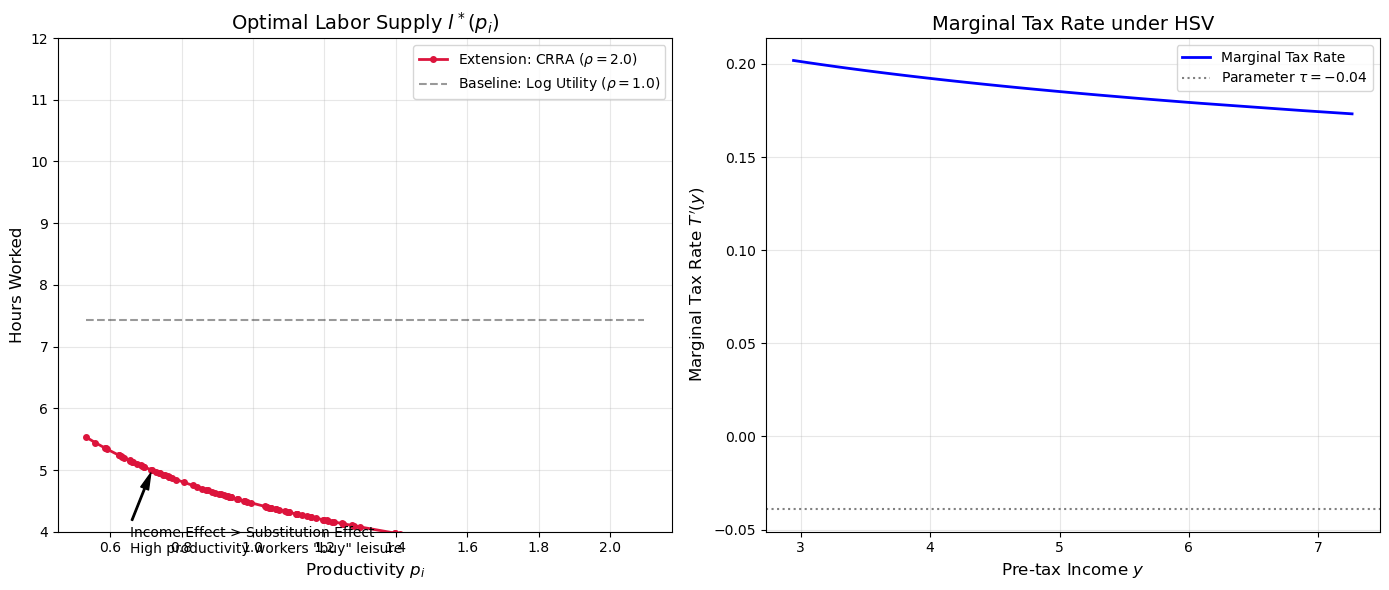

In [6]:
# 1. Define the CRRA + HSV Model 
class CRRAModelClass:
    def __init__(self, rho=2.0):
        self.par = SimpleNamespace()
        self.setup(rho)

    def setup(self, rho):
        # Standard parameters
        self.par.N = 100
        self.par.sigma_p = 0.3
        self.par.nu = 0.015
        self.par.epsilon = 1.0
        self.par.w = 1.0
        self.par.ell_max = 16.0
        
        # Government parameters
        self.par.chi = 50.0
        self.par.eta = 0.1
        
        # Extension Parameters
        self.par.rho = rho      # Risk Aversion (1.0 = Log, >1 = Strong Income Effect)
        self.par.lam = 1.0      # Tax Scale
        self.par.tau_hsv = 0.0  # Tax Progressivity

        # Draw Productivities (Sorted)
        rng = np.random.default_rng(12345)
        mu = -0.5 * self.par.sigma_p**2
        self.p_vec = np.sort(rng.lognormal(mu, self.par.sigma_p, self.par.N))

    def utility(self, c, l):
        par = self.par
        if c <= 0: return -np.inf
        
        # CRRA Utility for consumption
        if abs(par.rho - 1.0) < 1e-6:
            u_c = np.log(c)
        else:
            u_c = (c**(1 - par.rho)) / (1 - par.rho)
            
        disutility = par.nu * (l**(1 + par.epsilon)) / (1 + par.epsilon)
        return u_c - disutility

    def solve_worker(self, p):
        par = self.par
        
        # Define objective for the worker given current tax params
        def obj(l):
            if l <= 0: return np.inf
            y = par.w * p * l
            c = par.lam * (y**(1 - par.tau_hsv))
            return -self.utility(c, l)

        # Bounded minimization
        res = minimize_scalar(obj, bounds=(1e-6, par.ell_max), method='bounded')
        
        l_star = res.x
        y = par.w * p * l_star
        c_star = par.lam * (y**(1 - par.tau_hsv))
        tax = y - c_star
        return l_star, c_star, tax, -res.fun

    def evaluate_system(self, lam, tau_hsv):
        self.par.lam = lam
        self.par.tau_hsv = tau_hsv
        
        total_rev = 0
        total_util = 0
        l_vec = []
        c_vec = []
        
        for p in self.p_vec:
            l, c, tax, u = self.solve_worker(p)
            total_rev += tax
            total_util += u
            l_vec.append(l)
            c_vec.append(c)
            
        if total_rev < 0: return -np.inf, None, None
        
        # Standard SWF form
        swf = self.par.chi * (total_rev**self.par.eta) + total_util
        return swf, np.array(l_vec), np.array(c_vec)

# 2. Optimize the New Economy (rho=2.0) 
print("Initializing Model with CRRA Utility (rho=2.0)...")
model_crra = CRRAModelClass(rho=2.0)

def objective(x):
    lam, tau = x
    if lam <= 0.01 or tau >= 0.95 or tau < -0.5: return np.inf
    
    swf, _, _ = model_crra.evaluate_system(lam, tau)
    if swf == -np.inf: return np.inf
    return -swf

print("Optimizing Tax System...")

# Initial guess
res = minimize(objective, [0.8, 0.1], method='Nelder-Mead', tol=1e-4)

opt_lam = res.x[0]
opt_tau = res.x[1]
print(f"Optimal Result: lambda={opt_lam:.4f}, tau={opt_tau:.4f}")

# 3. Generate Data for Comparison 

# A. The new "Better" model (rho=2.0)
_, l_crra, c_crra = model_crra.evaluate_system(opt_lam, opt_tau)

# B. The previous "Flat" model (rho=1.0) for context
model_log = CRRAModelClass(rho=1.0)
_, l_log, _ = model_log.evaluate_system(0.82, 0.17) 

# 4. Plotting 
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Labor Supply Comparison
axes[0].plot(model_crra.p_vec, l_crra, 'o-', color='crimson', linewidth=2, markersize=4, label='Extension: CRRA ($\\rho=2.0$)')
axes[0].plot(model_log.p_vec, l_log, 'k--', alpha=0.4, label='Baseline: Log Utility ($\\rho=1.0$)')

axes[0].set_title('Optimal Labor Supply $l^*(p_i)$', fontsize=14)
axes[0].set_xlabel('Productivity $p_i$', fontsize=12)
axes[0].set_ylabel('Hours Worked', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(4, 12)

# Add annotation explaining the slope
text_x = model_crra.p_vec[10]
text_y = l_crra[10] - 1.5
axes[0].annotate('Income Effect > Substitution Effect\nHigh productivity workers "buy" leisure', 
                 xy=(model_crra.p_vec[20], l_crra[20]), 
                 xytext=(text_x, text_y),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6))


# Plot 2: Tax Progressivity (Marginal Tax Rate)
y_vec = model_crra.par.w * model_crra.p_vec * l_crra
mtr = 1 - opt_lam * (1 - opt_tau) * (y_vec**(-opt_tau))

axes[1].plot(y_vec, mtr, 'b-', linewidth=2, label='Marginal Tax Rate')
axes[1].set_title('Marginal Tax Rate under HSV', fontsize=14)
axes[1].set_xlabel('Pre-tax Income $y$', fontsize=12)
axes[1].set_ylabel('Marginal Tax Rate $T\'(y)$', fontsize=12)
axes[1].axhline(opt_tau, color='gray', linestyle=':', label=f'Parameter $\\tau={opt_tau:.2f}$')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The extension shows that allowing for CRRA preferences fundamentally changes labor supply behavior, as income effects dominates for high-productivity workers. This leads to a declining labor supply with productivity, which is not present under log utility. As a result, the optimal tax system adapts by smoothing marginal tax rates rather than relying on sharp progressivity. Overall, the extension highlights the importance of preference assumptions for optimal tax design and redistribution outcomes.